# Sprint1課題 機械学習フロー

1回目のSprintでは、機械学習の実践的な流れを抑えます。このSprintはWeek3,4の延長になり、引き続きKaggleの Home Credit Default Risk コンペティションを用います。特にここでは適切な 検証 を組み込むことを重視し、その上で前処理やモデルの選定を進めていきます。

適切な検証を行い、テストデータに対して高い汎化性能を持つモデルを完成させましょう。

[Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk)

# 方向性の整理

- 入力：Home Credit Default Risk


- プロセス：
  1. データセットを学習用データ、テストデータに分割する
  2. モデルの選定
  3. 学習
  4. 予測


- 出力：融資先のタイプの予測値（＝ 債務不履行を起こす or 起こさない）→ 分類問題

# 目標

- What : KFolds cross-validatorとは何か（何を入力として、何を出力するのか）理解する 
- Why : KFolds cross-validatorがなぜ必要なのか理解する
- How : KFolds cross-validatorの使い方（method）を理解する

## 事前準備

In [1]:
# モジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, auc, roc_curve, roc_auc_score

import pprint

# 【問題1】クロスバリデーション

事前学習期間は検証用データを分割しておき、それに対して指標値を計算することで検証を行っていました。しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション を行います。

具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnにKFoldとして用意されています。

[sklearn.model_selection.KFold¶](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

[sklearn.model_selection.StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

### 1. KFoldとは？

[Function]
- データを学習用/テスト用に分割するための学習用/テスト用インデックスを提供する。
- データセットをk個の連続する束（fold）に分割する（デフォルトではシャッフルしない）。

[Parameters]
- n_splits : 束（fold）の数。n_splitsは２以上の整数値をとる。
- shuffle : 分割前にデータをシャッフルするか否か（Default： False）
- random_state : ランダムな値の生成器のシード値。

### 公式ドキュメントのサンプルを動かしてみる（シャッフルなし）

In [2]:
X = np.arange(8).reshape(4,2)
y = np.arange(4)

print("X:", X)
print("")
print("y", y)
print("")

# インスタンスを生成する
kf = KFold(n_splits=2)

# 交差検定の分割回数を返す
kf.get_n_splits(X) # 2

# インスタンスを返す
print(kf) # KFold(n_splits=2, random_state=None, shuffle=False)
print("")

# 出力
print("KFold.split()の出力を確認する")
print("")

# パターンをカウントする変数
pattern = 1

# 学習用データ、テストデータを生成する
for train_index, test_index in kf.split(X):
    print("[分割パターン:{}]".format(pattern))
    print("インデックス", "Train:", train_index, "TEST", test_index)
    print("")
    
    X_train, X_test = X[train_index], X[test_index] # 学習データ、テストデータを生成
    y_train, y_test = y[train_index], y[test_index] # 学習データ、テストデータを生成
    
    print("X_train:", X_train, "X_test:", X_test, "y_train:", y_train, "y_test", y_test)
    print("")
    pattern += 1

X: [[0 1]
 [2 3]
 [4 5]
 [6 7]]

y [0 1 2 3]

KFold(n_splits=2, random_state=None, shuffle=False)

KFold.split()の出力を確認する

[分割パターン:1]
インデックス Train: [2 3] TEST [0 1]

X_train: [[4 5]
 [6 7]] X_test: [[0 1]
 [2 3]] y_train: [2 3] y_test [0 1]

[分割パターン:2]
インデックス Train: [0 1] TEST [2 3]

X_train: [[0 1]
 [2 3]] X_test: [[4 5]
 [6 7]] y_train: [0 1] y_test [2 3]



### 公式ドキュメントのサンプルを動かしてみる（シャッフルあり）

In [3]:
X = np.arange(8).reshape(4,2)
y = np.arange(4)

print("X:", X)
print("")
print("y", y)
print("")

# インスタンスを生成する
kf = KFold(n_splits=2, shuffle = True) # シャッフルしてみる

# 交差検定の分割回数を返す
kf.get_n_splits(X) # 2

# インスタンスを返す
print(kf) # KFold(n_splits=2, random_state=None, shuffle=False)
print("")

# 出力
print("KFold.split()の出力を確認する")
print("")

# パターンをカウントする変数
pattern = 1

# 学習用データ、テストデータを生成する
for train_index, test_index in kf.split(X):
    print("[分割パターン:{}]".format(pattern))
    
    print("インデックス", "Train:", train_index, "TEST", test_index)
    print("")
    
    X_train, X_test = X[train_index], X[test_index] # 学習データ、テストデータを生成
    y_train, y_test = y[train_index], y[test_index] # 学習データ、テストデータを生成
    
    print("X_train:", X_train, "X_test:", X_test, "y_train:", y_train, "y_test", y_test)
    print("")
    pattern += 1

X: [[0 1]
 [2 3]
 [4 5]
 [6 7]]

y [0 1 2 3]

KFold(n_splits=2, random_state=None, shuffle=True)

KFold.split()の出力を確認する

[分割パターン:1]
インデックス Train: [1 3] TEST [0 2]

X_train: [[2 3]
 [6 7]] X_test: [[0 1]
 [4 5]] y_train: [1 3] y_test [0 2]

[分割パターン:2]
インデックス Train: [0 2] TEST [1 3]

X_train: [[0 1]
 [4 5]] X_test: [[2 3]
 [6 7]] y_train: [0 2] y_test [1 3]



### 考察

- KFoldを用いるとデータセットを指定した数に分割することを確認できた。
- 具体的には、KFold.split()による出力が、学習用データ／検証用データのインデックスであることを確認できた。
- パラメータshuffleをTrueにすることで、.出力されるインデックスがshuffleされることを確認した。

### 2. StratifiedKFoldとは？

[Function]
- データを学習用/テスト用に分割するための学習用/テスト用インデックスを提供します。
- この交差検定オブジェクトは、階層化された折り畳みを返すKFoldの変形。
- 束（folds）は、各クラスのサンプルの割合を保存することによって作成される。

[Parameters]
- n_splits : 束（fold）の数。n_splitsは２以上の整数値をとる。
- shuffle : 分割前にデータをシャッフルするか否か（Default： False）
- random_state : ランダムな値の生成器のシード値。

In [4]:
# 何が出力されるのか試してみる

X = np.arange(24).reshape(12,2)
y = np.array([0,0,0, 0,1,1,1,1, 2, 2,2,2]) # 正解ラベルの数を3つずつにセット

print("学習用データ(X) ／ テストデータ(y)")
print("")

print("X:", X)
print("")
print("y", y)
print("")

# インスタンスの生成
skf = StratifiedKFold(n_splits = 4)

# インスタンスを返す
print("インスタンス：", skf) # StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
print("")

# 分割パターン
print("分割パターンは以下{}通り：".format(skf.get_n_splits(X, y)))
print("")

# パターンをカウントする変数
pattern = 1

# 学習用データ、テストデータを確認する
for train_index, test_index in skf.split(X, y):
    print("[分割パターン:{}]".format(pattern))
    
    print("インデックス:", "TRAIN", train_index, "TEST", test_index)
    print("")
    
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    print("X_train:", X_train, "X_test:", X_test, "y_train:", y_train, "y_test", y_test)
    print("")
    pattern += 1

学習用データ(X) ／ テストデータ(y)

X: [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]
 [20 21]
 [22 23]]

y [0 0 0 0 1 1 1 1 2 2 2 2]

インスタンス： StratifiedKFold(n_splits=4, random_state=None, shuffle=False)

分割パターンは以下4通り：

[分割パターン:1]
インデックス: TRAIN [ 1  2  3  5  6  7  9 10 11] TEST [0 4 8]

X_train: [[ 2  3]
 [ 4  5]
 [ 6  7]
 [10 11]
 [12 13]
 [14 15]
 [18 19]
 [20 21]
 [22 23]] X_test: [[ 0  1]
 [ 8  9]
 [16 17]] y_train: [0 0 0 1 1 1 2 2 2] y_test [0 1 2]

[分割パターン:2]
インデックス: TRAIN [ 0  2  3  4  6  7  8 10 11] TEST [1 5 9]

X_train: [[ 0  1]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [12 13]
 [14 15]
 [16 17]
 [20 21]
 [22 23]] X_test: [[ 2  3]
 [10 11]
 [18 19]] y_train: [0 0 0 1 1 1 2 2 2] y_test [0 1 2]

[分割パターン:3]
インデックス: TRAIN [ 0  1  3  4  5  7  8  9 11] TEST [ 2  6 10]

X_train: [[ 0  1]
 [ 2  3]
 [ 6  7]
 [ 8  9]
 [10 11]
 [14 15]
 [16 17]
 [18 19]
 [22 23]] X_test: [[ 4  5]
 [12 13]
 [20 21]] y_train: [0 0 0 1 1 1 2 2 2] y_test [0 1 2]

[分割パターン:4]
インデックス: TRAIN [

### StratifiedKFoldの考察

- 取り得る分割パターン（n_splits）の最大値は、目的変数に含まれる各カテゴリの要素数の最小値となる。

- 例えば、目的変数が[0,0,0,0,1,1,2,2,2]の場合、要素数が最小のカテゴリは１で要素数は2であるから、n_splitsは3以上の値を取ることができない。

- 十分なサンプル数を有するデータを扱う場合には、n_splitsの値は然程きにする必要はないと思われる。

## KFold, StratifiedKFoldを実際に使ってみる

1. train_test_split()を用いて学習・予測・評価を行う。

2. cross_validation()を組み込んで学習・予測・評価を行う。

In [5]:
# データセットの準備
df_train = pd.read_csv("application_train.csv")

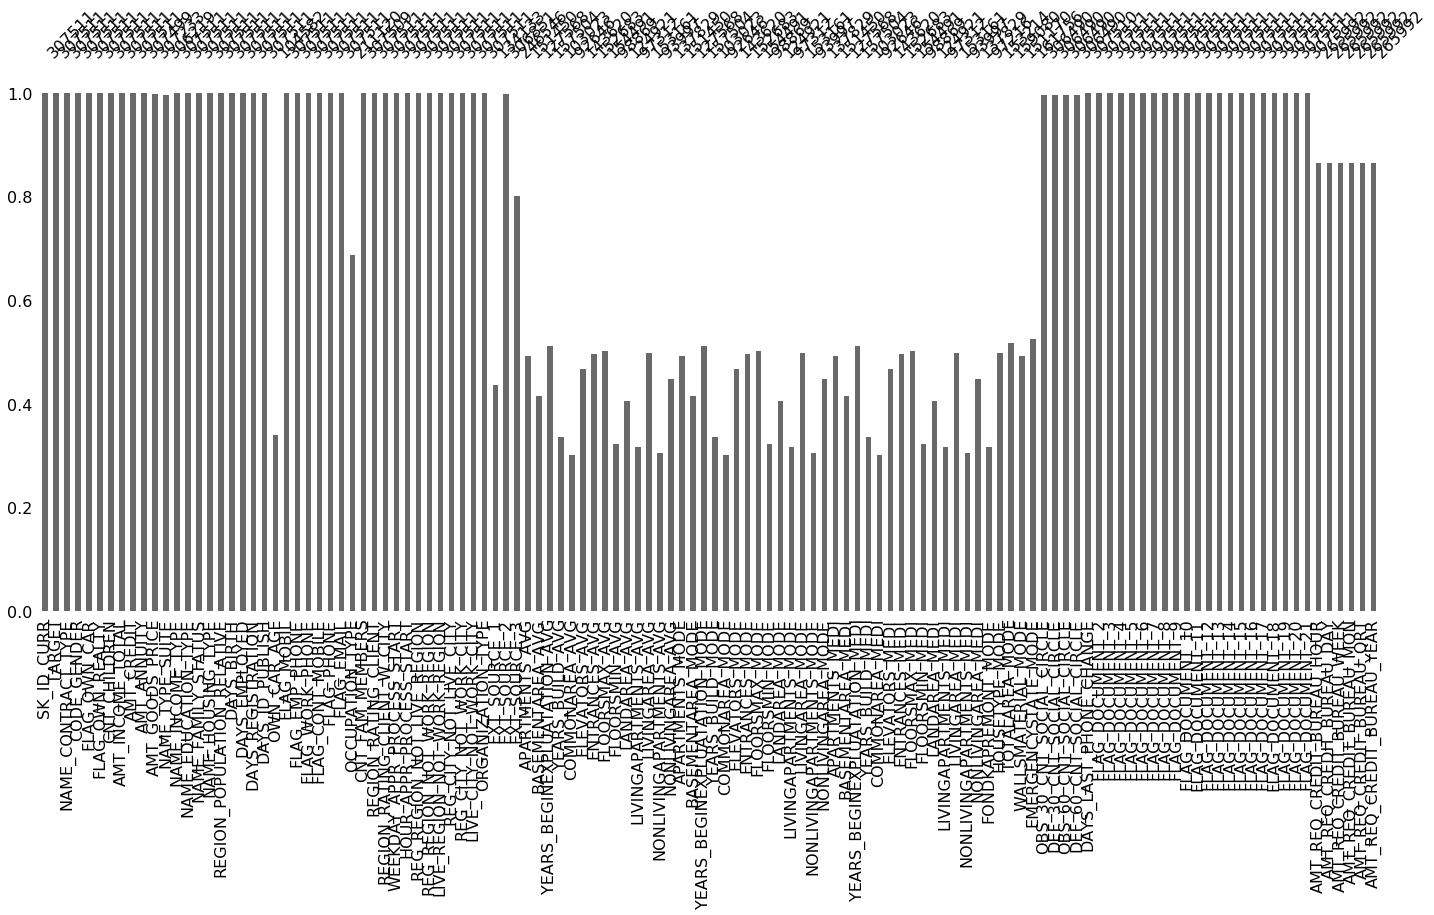

In [6]:
# 欠損確認

msno.bar(df_train)

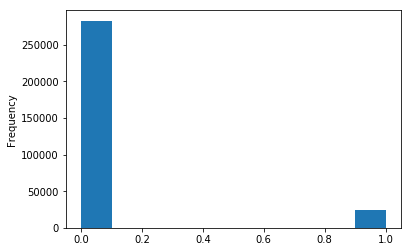

In [7]:
# データセットに含まれる目的変数の不均衡度を確認
df_train["TARGET"].astype(int).plot.hist()

今回の分析では、以下を説明変数として取り上げることとした。

(説明変数)

- EXT_SOURCE_1
- EXT_SOURCE_2
- EXT_SOURCE_3

In [8]:
# 学習用データから説明変数、目的変数を抽出する

columns = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"] # 説明変数の列ラベル

df_X = df_train[columns] # 説明変数を抽出する
df_y = df_train["TARGET"] # 目的変数を抽出する

In [9]:
df_X.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,0.083037,0.262949,0.139376
1,0.311267,0.622246,NaN
2,NaN,0.555912,0.729567
3,NaN,0.650442,NaN
4,NaN,0.322738,NaN


In [10]:
# Xの欠損値を平均値(mean)で補完
df_X = df_X.fillna(X.mean())
df_X.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,0.083037,0.262949,0.139376
1,0.311267,0.622246,11.500000
2,11.500000,0.555912,0.729567
3,11.500000,0.650442,11.500000
4,11.500000,0.322738,11.500000


In [11]:
df_y.head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

In [12]:
# Numpy配列に変換する
X = df_X.values
y = df_y.values

In [13]:
X

array([[ 0.08303697,  0.26294859,  0.13937578],
       [ 0.31126731,  0.62224578, 11.5       ],
       [11.5       ,  0.55591208,  0.72956669],
       ...,
       [ 0.7440264 ,  0.53572175,  0.21885908],
       [11.5       ,  0.51416282,  0.66102354],
       [ 0.73445967,  0.7085689 ,  0.1139224 ]])

# Pipelineを準備する

推定器（Estimator）は以下３種類を用いる

1. Logistic Regression
2. 決定木

In [14]:
# stepの準備

steps_LR = [("ss",StandardScaler()), ("LR", LogisticRegression(class_weight = "balanced", random_state = 1))]
steps_DT = [("ss",StandardScaler()), ("DT", DecisionTreeClassifier(class_weight = "balanced", random_state = 1))]

In [15]:
# パイプラインを用いて推定器のインスタンスを生成

clf_LR = Pipeline(steps_LR) # Logistic Regression
clf_DT = Pipeline(steps_DT) # Decision Tree Classifier

## 1. train_test_split()を用いる

In [16]:
# 学習用データ、テストデータを生成する

X_train, X_test, y_train, y_test = train_test_split(X, y)

### 1 - 1. Logistic Regression

In [17]:
# 学習
clf_LR.fit(X_train, y_train)

# 予測
y_pred = clf_LR.predict(X_test)

# 評価結果のラベル
columns = ["accuracy_score", "precision_score", "recall_score", "f1_score", "auc"]

# 評価結果を格納するデータフレーム
df_eval = pd.DataFrame(index = [1], columns = columns)

# Evaluation
df_eval.at[1, "accuracy_score"] = np.round(accuracy_score(y_test, y_pred), 2)
df_eval.at[1, "precision_score"] = np.round(precision_score(y_test, y_pred), 2)
df_eval.at[1, "recall_score"] = np.round(recall_score(y_test, y_pred), 2)
df_eval.at[1, "f1_score"] = np.round(f1_score(y_test, y_pred), 2)
df_eval.at[1, "auc"] = np.round(roc_auc_score(y_test, y_pred), 2)

# 平均aucを出力
mean_auc = df_eval["auc"].mean()
print("mean_auc : {}".format(mean_auc))

# スコアを出力
df_eval

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


mean_auc : 0.61


,accuracy_score,precision_score,recall_score,f1_score,auc
1,0.66,0.13,0.54,0.21,0.61


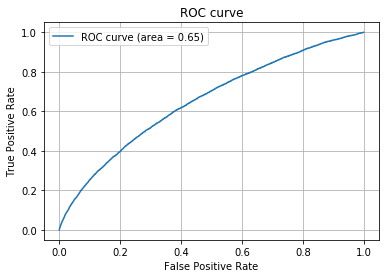

In [18]:
# 可視化

y_pred_proba = clf_LR.predict_proba(X_test)[:,1]

# FPR, TPR、閾値 を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

# AUC
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

# 1 - 2. 決定木

In [19]:
# 学習
clf_DT.fit(X_train, y_train)

# 予測
y_pred = clf_DT.predict(X_test)


# 評価結果のラベル
columns = ["accuracy_score", "precision_score", "recall_score", "f1_score", "auc"]

# 評価結果を格納するデータフレーム
df_eval = pd.DataFrame(index = [1], columns = columns)

# Evaluation
df_eval.at[1, "accuracy_score"] = np.round(accuracy_score(y_test, y_pred), 2)
df_eval.at[1, "precision_score"] = np.round(precision_score(y_test, y_pred), 2)
df_eval.at[1, "recall_score"] = np.round(recall_score(y_test, y_pred), 2)
df_eval.at[1, "f1_score"] = np.round(f1_score(y_test, y_pred), 2)
df_eval.at[1, "auc"] = np.round(roc_auc_score(y_test, y_pred), 2)

# 平均aucを出力
mean_auc = df_eval["auc"].mean()
print("mean_auc : {}".format(mean_auc))

# スコアを出力
df_eval

mean_auc : 0.53


,accuracy_score,precision_score,recall_score,f1_score,auc
1,0.86,0.14,0.14,0.14,0.53


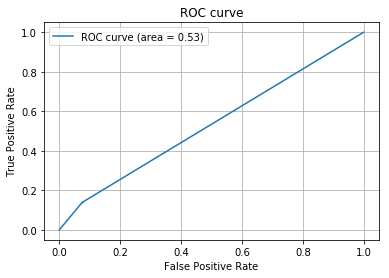

In [20]:
# 可視化

y_pred_proba = clf_DT.predict_proba(X_test)[:,1]

# FPR, TPR、閾値 を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

# AUC
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## 2. Cross Validationを使ってみる

### 2-1. KFold

分割数（kfold）は5とする。

#### 2-1-1. Logistic Regression

In [21]:
# インスタンスの生成
kfold = 5
kf = KFold(n_splits = kfold)

# 空配列を用意する
columns = ["accuracy_score", "precision_score", "recall_score", "f1_score", "auc"]

# 評価結果を格納するデータフレーム
df_eval = pd.DataFrame(index = np.arange(1, kfold + 1), columns = columns)

# Cross Validationのパターン
pattern = 1

# 学習、予測、評価
for train_index, test_index in kf.split(X, y):
    
    # 学習データ、テストデータを生成
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    # 学習
    clf_LR.fit(X_train, y_train)
    
    # 予測
    y_pred_LR = clf_LR.predict(X_test)
    
    #  スコアを算出して、データフレームに格納
    df_eval.at[pattern, "accuracy_score"] = np.round(accuracy_score(y_test, y_pred_LR), 2)
    df_eval.at[pattern, "precision_score"] = np.round(precision_score(y_test, y_pred_LR), 2)
    df_eval.at[pattern, "recall_score"] = np.round(recall_score(y_test, y_pred_LR), 2)
    df_eval.at[pattern, "f1_score"] = np.round(f1_score(y_test, y_pred_LR), 2)
    df_eval.at[pattern, "auc"] = np.round(roc_auc_score(y_test, y_pred_LR), 2)
    
    pattern += 1

# 平均aucを出力
mean_auc = df_eval["auc"].mean()
print("mean_auc : {}".format(mean_auc))

# スコアを出力
df_eval

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

mean_auc : 0.61


,accuracy_score,precision_score,recall_score,f1_score,auc
1,0.67,0.13,0.54,0.21,0.61
2,0.67,0.13,0.55,0.21,0.61
3,0.66,0.13,0.54,0.21,0.61
4,0.67,0.13,0.54,0.21,0.61
5,0.67,0.13,0.54,0.21,0.61


### 2-1-2. 決定木

In [22]:
# インスタンスの生成
kfold = 5
kf = KFold(n_splits = kfold)

# 空配列を用意する
columns = ["accuracy_score", "precision_score", "recall_score", "f1_score", "auc"]

# 評価結果を格納するデータフレーム
df_eval = pd.DataFrame(index = np.arange(1, kfold + 1), columns = columns)

# Cross Validationのパターン
pattern = 1

# 学習、予測、評価
for train_index, test_index in kf.split(X, y):
    
    # 学習データ、テストデータを生成
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]

    # 学習
    clf_DT.fit(X_train, y_train)
    
    # 予測
    y_pred_DT = clf_DT.predict(X_test)
    
    #  スコアを算出して、データフレームに格納
    df_eval.at[pattern, "accuracy_score"] = np.round(accuracy_score(y_test, y_pred_DT), 2)
    df_eval.at[pattern, "precision_score"] = np.round(precision_score(y_test, y_pred_DT), 2)
    df_eval.at[pattern, "recall_score"] = np.round(recall_score(y_test, y_pred_DT), 2)
    df_eval.at[pattern, "f1_score"] = np.round(f1_score(y_test, y_pred_DT), 2)
    df_eval.at[pattern, "auc"] = np.round(roc_auc_score(y_test, y_pred_DT), 2)
    
    pattern += 1

# 平均aucを出力
mean_auc = df_eval["auc"].mean()
print("mean_auc : {}".format(mean_auc))

# スコアを出力
df_eval

mean_auc : 0.53


,accuracy_score,precision_score,recall_score,f1_score,auc
1,0.86,0.13,0.14,0.14,0.53
2,0.86,0.14,0.14,0.14,0.53
3,0.86,0.14,0.14,0.14,0.53
4,0.86,0.13,0.13,0.13,0.53
5,0.86,0.13,0.14,0.14,0.53


## 2. Stratified KFold

分割数（kfold）は5とする。

#### 2-2-1. Logistic Regression

In [23]:
# インスタンスの生成
kfold = 5
skf = StratifiedKFold(n_splits = kfold)

# 空配列を用意する
columns = ["accuracy_score", "precision_score", "recall_score", "f1_score", "auc"]

# 評価結果を格納するデータフレーム
df_eval = pd.DataFrame(index = np.arange(1, kfold + 1), columns = columns)

# Cross Validationのパターン
pattern = 1

# 学習、予測、評価
for train_index, test_index in skf.split(X, y):
    
    # 学習データ、テストデータを生成
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]

    # 学習
    clf_LR.fit(X_train, y_train)
    
    # 予測
    y_pred_LR = clf_LR.predict(X_test)
    
    #  スコアを算出して、データフレームに格納
    df_eval.at[pattern, "accuracy_score"] = np.round(accuracy_score(y_test, y_pred_LR), 2)
    df_eval.at[pattern, "precision_score"] = np.round(precision_score(y_test, y_pred_LR), 2)
    df_eval.at[pattern, "recall_score"] = np.round(recall_score(y_test, y_pred_LR), 2)
    df_eval.at[pattern, "f1_score"] = np.round(f1_score(y_test, y_pred_LR), 2)
    df_eval.at[pattern, "auc"] = np.round(roc_auc_score(y_test, y_pred_LR), 2)
    
    pattern += 1

# 平均aucを出力
mean_auc = df_eval["auc"].mean()
print("mean_auc : {}".format(mean_auc))

# スコアを出力
df_eval

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

mean_auc : 0.61


,accuracy_score,precision_score,recall_score,f1_score,auc
1,0.67,0.13,0.54,0.21,0.61
2,0.67,0.13,0.55,0.21,0.61
3,0.66,0.13,0.54,0.21,0.61
4,0.67,0.13,0.54,0.21,0.61
5,0.67,0.13,0.54,0.21,0.61


#### 2-2-2. 決定木

In [24]:
# インスタンスの生成
kfold= 5
skf = StratifiedKFold(n_splits = kfold)

# 空配列を用意する
columns = ["accuracy_score", "precision_score", "recall_score", "f1_score", "auc"]

# 評価結果を格納するデータフレーム
df_eval = pd.DataFrame(index = np.arange(1, kfold + 1), columns = columns)

# Cross Validationのパターン
pattern = 1

# 学習、予測、評価
for train_index, test_index in skf.split(X, y):
    
    # 学習データ、テストデータを生成
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]

    # 学習
    clf_DT.fit(X_train, y_train)
    
    # 予測
    y_pred_DT = clf_DT.predict(X_test)
    
    #  スコアを算出して、データフレームに格納
    df_eval.at[pattern, "accuracy_score"] = np.round(accuracy_score(y_test, y_pred_DT), 2)
    df_eval.at[pattern, "precision_score"] = np.round(precision_score(y_test, y_pred_DT), 2)
    df_eval.at[pattern, "recall_score"] = np.round(recall_score(y_test, y_pred_DT), 2)
    df_eval.at[pattern, "f1_score"] = np.round(f1_score(y_test, y_pred_DT), 2)
    df_eval.at[pattern, "auc"] = np.round(roc_auc_score(y_test, y_pred_DT), 2)
    
    pattern += 1

# 平均aucを出力
mean_auc = df_eval["auc"].mean()
print("mean_auc : {}".format(mean_auc))

# スコアを出力
df_eval

mean_auc : 0.53


,accuracy_score,precision_score,recall_score,f1_score,auc
1,0.86,0.13,0.14,0.14,0.53
2,0.86,0.14,0.14,0.14,0.53
3,0.86,0.14,0.14,0.14,0.53
4,0.86,0.13,0.14,0.13,0.53
5,0.86,0.13,0.14,0.14,0.53


# 【問題2】グリッドサーチ

これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。

パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。

パラメータを探索するために グリッドサーチ と呼ばれる総当たり的手法が一般的に利用されます。

グリッドサーチをパイプラインの中に組み込みましょう。

## GridSearchCVについて調べてみた

[Reference]
[sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

---
[Summary]
1. そもそも何をするもの？
    - **estimatorの最適パラメーターを総当たりで探索する** (Exhaustive search over specified parameter values for an estimator.) → 一言で言えば、solverみたいなもの
    
    - fit, predictが重要 (Important members are fit, predict.)
    
    - GridSearchCVで実行するメソッドは以下の通り。最適なパラメーターセットでfitしたモデルに関するものが多い。
        - **fit(X[, y, groups])** :　パラメーターの全組み合わせでモデルをfitする(Run fit with all sets of parameters.)
        - **score(X[, y])** : スコアを返す(Returns the score on the given data, if the estimator has been refit.)
        - **predict(X)** : 最適なパラメーターセットにおける予測値を出力する(Call predict on the estimator with the best found parameters.)
        - **predict_proba(X)** : 最適なパラメーターセットにおける予測確率を返す(Call predict_proba on the estimator with the best found parameters.)
        - **decision_function()** : 最適なパラメーターセットにおけるestimatorの決定関数（データポイントの陽性/陰性の確信度を返す関数)を返す(Call decision_function on the estimator with the best found parameters.)
        - **transform()** : 最適なパラメーターセットにおけるestimaterのtransformを返す (Call transform on the estimator with the best found parameters.)
        - **inverse_transform()** : 最適なパラメーターセットにおけるestimatorのinverse_transformを返す(Call inverse_transform on the estimator with the best found params.)


2. なぜ必要？（pros-consは？）
    - pros：少ないコード量で様々なパターンの検証を実行できる。
    - cons：組み合わせ不可なパラメーターもあることに注意が必要。

---
[Abstract]

1. class : sklearn.model_selection.

2. Parameter
    - estimator : This is assumed to implement the scikit-learn estimator interface. Either estimator needs to provide a score function, or scoring must be passed.
    - param_grid : Dictionary with parameters names (string) as keys and lists of parameter settings to try as values, or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored. This enables searching over any sequence of parameter settings.
    - scoring : A single string or a callable to evaluate the predictions on the test set.
    - fit_params : Parameters to pass to the fit method.
    - n_jobs : Number of jobs to run in parallel. None means 1.
    - pre_dispatch : 
    - **iid : If True, return the average score across folds, weighted by the number of samples in each test set.**
    - **cv : Determines the cross-validation splitting strategy.** Possible inputs for cv are: None, int, CV splitter, An iterable yielding (train, test) splits as arrays of indices.
    - **refit : Refit an estimator using the best found parameters on the whole dataset.**
    - verbose : Controls the verbosity: the higher, the more messages.
    - error_score : 
    - return_train_score : 


3. Attributes
    - cv_results_ : A dict with keys as column headers and values as columns, that can be imported into a pandas DataFrame.
    - best_estimator_ : Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.
    - best_score : Mean cross-validated score of the best_estimator
    - best_params_ : Parameter setting that gave the best results on the hold out data.
    - best_index_ : The index (of the cv_results_ arrays) which corresponds to the best candidate parameter setting.
    - scorer_ : Scorer function used on the held out data to choose the best parameters for the model.
    - n_splits_ : The number of cross-validation splits (folds/iterations).
    - refit_time : Seconds used for refitting the best model on the whole dataset.

### GridSearchCVのサンプルを使ってみる。

In [25]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

# データを用意する
iris = datasets.load_iris()

# 組み合わせを試すパラメーターのセット
parameters = {"kernel":("linear", "rbf"), "C": [1, 10]}

# SVMのインスタンスを生成
svc = svm.SVC(gamma = "scale")

# GridSearchCVのインスタンスを生成（parametersの全ての組み合わせ）
clf = GridSearchCV(svc, parameters, cv = 5)

# フィッティング
clf.fit(iris.data, iris.target)

#　Attribute
print("best_params_")
print(clf.best_params_) # 最適なパラメーターセット
print("")

print("best_estimator_")
print(clf.best_estimator_) # 最適なパラメーターセットにおけるestimator
print("")

print("best_index_")
print(clf.best_index_)
print("")

print("n_splits_")
print(clf.n_splits_)
print("")

# 出力
iris_pred = clf.predict(iris.data)

best_params_
{'C': 1, 'kernel': 'linear'}

best_estimator_
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

best_index_
0

n_splits_
5



## 実際にパイプラインにGridSearchCVを組み込む

今回は、aucが相対的に高いスコアをとったLogistic Regressionに絞って実行する。

[step]

1. データを用意する
2. 組み合わせを試す推定器、パラメーターのセットを用意して、パイプラインを作成する
3. GridSearchCVのインスタンスを生成する
4. 学習（fitting）
5. 結果（predict）
6. 精度評価

In [26]:
# テストデータを作成
df_test = pd.read_csv("application_test.csv")

columns = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]

X_submission = df_test[columns]
X_submission = X_submission.fillna(X_submission.mean())

# 標準化
scaler = StandardScaler()
scaler.fit(X_submission)

X_submission = scaler.transform(X_submission)

In [27]:
# 1. データを用意する
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

print("説明変数")
print(X)
print("")
print("目的変数")
print(y)

説明変数
[[-1.21336364 -0.50645248 -0.58159696]
 [-1.17153066  0.15519234  2.00939182]
 [ 0.8792837   0.03303902 -0.44699362]
 ...
 [-1.09220902 -0.00414142 -0.56346941]
 [ 0.8792837  -0.04384214 -0.46262608]
 [-1.09396254  0.31415614 -0.58740205]]

目的変数
[1 0 0 ... 0 1 0]


In [28]:
# 2. パラメーターのセットを用意する(数値はリスト、文字列はタプルで与える)
lr = LogisticRegression(class_weight = "balanced", random_state = 1)

parameters = {"class_weight":(None, "balanced"),
              "penalty": ("l1", "l2"),
              "C": [0.001, 0.01, 0.1, 1.0, 10, 100]}

In [29]:
# 3. GridSearchCVのインスタンスを生成する
clf = GridSearchCV(lr, parameters, cv = 5)

In [30]:
# 4. 学習
kfold = 5
skf = StratifiedKFold(n_splits = kfold)

for train_index, test_index in skf.split(X, y):
    
    # 学習データ、テストデータを生成
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 学習
    clf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [31]:
# 5. GridSearchCVによる結果の出力
clf.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
# 6. 精度を評価する
print("mean_auc : {}".format(round(cross_val_score(clf.best_estimator_, X, y, cv = kfold, scoring = "roc_auc").mean(),3)))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


mean_auc : 0.655


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


最適なパラメーターセットを用いた場合、aucは約65%に改善した。

In [33]:
# テストデータを用いて予測
y_pred_proba = clf.best_estimator_.predict_proba(X_submission)[:,1]

# 出力
y_pred_proba

array([0.0281002 , 0.17998211, 0.04001406, ..., 0.05191153, 0.104942  ,
       0.10086941])

In [34]:
# submission用csv作成

df_submission = pd.DataFrame(df_test["SK_ID_CURR"])
df_submission["TARGET"] = y_pred_proba

df_submission.head()

,SK_ID_CURR,TARGET
0,100001,0.028100
1,100005,0.179982
2,100013,0.040014
3,100028,0.082877
4,100038,0.112844


In [35]:
# CSV出力
df_submission.to_csv("Home_Credit_Default_Risk1.csv", index=False)

# 【問題3】Kernelからの調査

KaggleのKernelから自身にはなかったアイデアを見つけ出して、列挙してください。そして、効果があると考えられるものを検証してください。

# 【問題4】高い汎化性能のモデル

これまで学んだことを用いながら汎化性能の高いモデルを作成してください。

以下、問題3と問題４を合わせて進めていく。

## Kaggleの参照結果

Kaggleを参照したところ、デフォルトの可能性に影響を及ぼし得る４つの特徴量があることが判明。これらを作成し、特徴量に追加してみたい。

[Start Here: A Gentle Introduction](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)

---

- **CREDIT_INCOME_PERCENT**: 対年収与信額率（年収に対する与信額の割合）

- **ANNUITY_INCOME_PERCENT**: 対年収年金受給額率（年収に占める年金受給額の割合）

- **CREDIT_TERM**: 与信期間

- **DAYS_EMPLOYED_PERCENT**: 対年齢就業日数率（顧客の年齢に対する就業日数の割合）
---

### 説明変数の新規作成

In [36]:
# データ生成
app_train_domain = df_train.copy()
app_test_domain = df_test.copy()

In [37]:
# 学習用データの作成
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']

app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']

app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']

app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [38]:
# 検証用データの作成
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']

app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']

app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']

app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


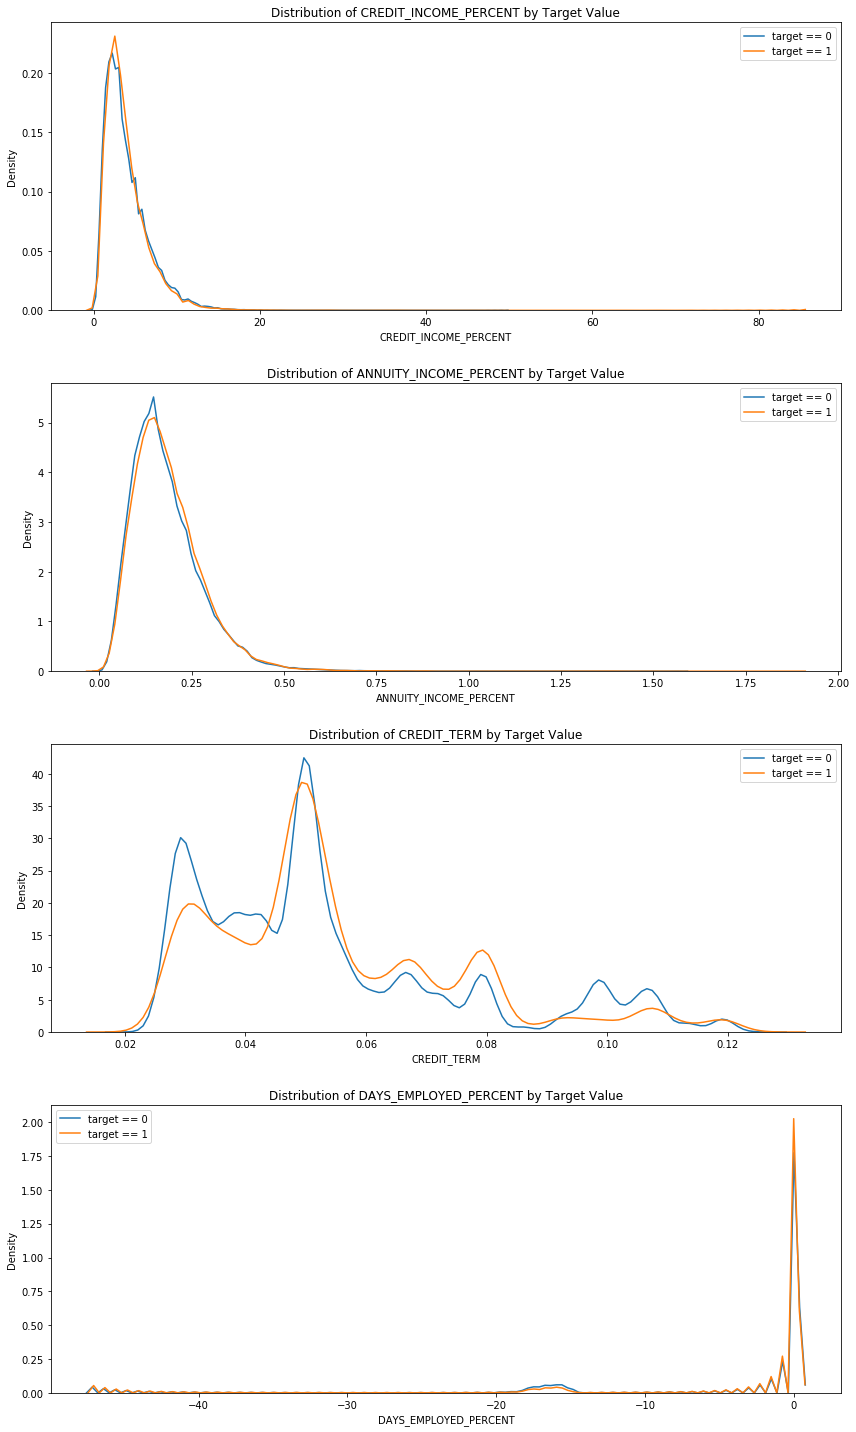

In [39]:
plt.figure(figsize = (12, 20))


for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    plt.subplot(4, 1, i + 1)
    
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### 説明変数の追加

In [43]:
# 対年収与信額率
credit_income_percent = pd.DataFrame(app_train_domain["CREDIT_INCOME_PERCENT"])

# 欠損値確認
credit_income_percent.isnull().sum() # 欠損値なし

CREDIT_INCOME_PERCENT    0
dtype: int64

In [44]:
# 対年収年金受給額率
annuity_income_percent = pd.DataFrame(app_train_domain["ANNUITY_INCOME_PERCENT"])

# 欠損値確認
annuity_income_percent.isnull().sum() # 欠損値あり

ANNUITY_INCOME_PERCENT    12
dtype: int64

In [47]:
# 欠損値を平均値で補完
annuity_income_percent = annuity_income_percent.fillna(annuity_income_percent.mean())
annuity_income_percent.isnull().sum()

ANNUITY_INCOME_PERCENT    0
dtype: int64

In [48]:
# 与信期間
credit_term = pd.DataFrame(app_train_domain["CREDIT_TERM"])

# 欠損値確認
credit_term.isnull().sum() # 欠損値あり

CREDIT_TERM    12
dtype: int64

In [49]:
# 欠損値を平均値で補完
credit_term = credit_term.fillna(credit_term.mean())
credit_term.isnull().sum()

CREDIT_TERM    0
dtype: int64

In [50]:
# 対年齢就業日数率
days_employed_percent = pd.DataFrame(app_train_domain["DAYS_EMPLOYED_PERCENT"])

# 欠損値確認
days_employed_percent.isnull().sum() # 欠損値あり

DAYS_EMPLOYED_PERCENT    0
dtype: int64

In [51]:
df_X.head() # 標準化前の説明変数

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,0.083037,0.262949,0.139376
1,0.311267,0.622246,11.500000
2,11.500000,0.555912,0.729567
3,11.500000,0.650442,11.500000
4,11.500000,0.322738,11.500000


In [52]:
df_X_new = pd.concat([df_X, credit_income_percent, annuity_income_percent, credit_term, days_employed_percent], axis = 1)
df_X_new.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,0.083037,0.262949,0.139376,2.007889,0.121978,0.060749,0.067329
1,0.311267,0.622246,11.500000,4.790750,0.132217,0.027598,0.070862
2,11.500000,0.555912,0.729567,2.000000,0.100000,0.050000,0.011814
3,11.500000,0.650442,11.500000,2.316167,0.219900,0.094941,0.159905
4,11.500000,0.322738,11.500000,4.222222,0.179963,0.042623,0.152418


## モデルを再作成する（Logistic Regression）

In [53]:
# 説明変数、目的変数の設定
X_new = df_X_new.values # 説明変数（標準化前）

scaler = StandardScaler()
scaler.fit(X_new)
X_new = scaler.transform(X_new) # 説明変数（標準化後）

print("説明変数")
print(X_new)
print("")
print("目的変数")
print(y)

説明変数
[[-1.21336364 -0.50645248 -0.58159696 ... -0.62335952  0.31379166
   0.45079593]
 [-1.17153066  0.15519234  2.00939182 ... -0.51509375 -1.16084631
   0.45132903]
 [ 0.8792837   0.03303902 -0.44699362 ... -0.85575202 -0.16436296
   0.44241887]
 ...
 [-1.09220902 -0.00414142 -0.56346941 ...  0.15872771 -0.4206385
   0.52050036]
 [ 0.8792837  -0.04384214 -0.46262608 ... -0.66375087  0.0399151
   0.50101479]
 [-1.09396254  0.31415614 -0.58740205 ...  1.3844204   0.84835606
   0.45193376]]

目的変数
[1 0 0 ... 0 1 0]


In [54]:
# 2. パラメーターのセットを用意する(数値はリスト、文字列はタプルで与える)
lr_new = LogisticRegression(class_weight = "balanced", random_state = 1)

parameters = {"penalty": ("l1", "l2"),
              "C": [0.001, 0.01, 0.1, 1.0, 10, 100]}

In [55]:
# 3. GridSearchCVのインスタンスを生成する
clf_new = GridSearchCV(lr_new, parameters, cv = 5)

In [56]:
# 4. 学習
kfold = 5 # データの分割数
skf = StratifiedKFold(n_splits = kfold) # インスタンス生成

for train_index, test_index in skf.split(X_new, y):
    
    # 学習データ、テストデータを生成
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 学習
    clf_new.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [57]:
# 5. GridSearchCVによる結果の出力
clf_new.best_estimator_

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=1,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [58]:
# 6. 精度を評価する

print("mean_auc : {}".format(round(cross_val_score(clf_new.best_estimator_, X_new, y, cv = kfold, scoring = "roc_auc").mean(), 3)))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

mean_auc : 0.661


# 結果に対する考察

- 新たに特徴量を４つ追加し、同じモデル（ロジスティック回帰）で評価したところ、aucは0.661となった。


- 特徴量を追加する前のaucは0.655であり、大幅な改善は見られなかった。


- 今回は欠損値を各特徴量の平均値で補完したが、dropしても良かったかもしれない。

# 本課題からの学び

1. 学習データにおける要素の分布の偏りは、モデルの学習において、underfitting, overfittingの原因となる。交差検定（Cross Validation）に関して以下を理解した。

   - **交差検定とは何か？ なぜ行うのか？** ： 学習データを分割し、学習データ、検証データのセットを複数（最低２セット以上）作成し、モデルの予測精度の安定性を検証すること。
   
   - **交差検定の種類** : KFold, StratifiedKFold（データを分割した後、各分割を再分割してサンプリングする）など複数ある。分割前に学習データをシャッフルするか否かをパラメータで選択できる。


2. GridSearchCVを用いてモデルの最適なパラメーター（best_estimator_）を発見できると分かったので、今後も活用していきたい。


3. KaggleのKernelから、データ分析の切り口として参考になる。自前にこだわり過ぎず、先人から学ぶことも大事にしたい。


4. 変数名、インスタンス名を揃えてしまい、"object is not callable."というerrorが頻発した。今後は、変数名とインスタンス名を揃えないようにする。（合わせて変数宣言に関するルールを確認する）


5. 今回のデータセットは正解値のサンプル数が不均衡である（＝正解値0のサンプル数が極端に多い）ため、精度が出にくいのではないかと考えている。不均衡データの取り扱いに関してさらに理解を深めたい。